In [1]:
from pathlib import Path
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

exec(open("functions.py").read())

In [166]:
# set basic parameters and subdirectory
part_n = 500
e_part_r = 0.8
e_mean = 4
ei_std_s = [4, 4]
waiting_time = 300
interval_len = waiting_time + 1280#2560
freq = 0

In [195]:
# generate and save parameters for simulation
seed = round(time.time())
print(seed)
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.array([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean)
unscaled_std = jnp.tile(jnp.array([ei_std_s]), (2, 1))
connectivity_n = 1
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(
  connectivity_s_generator(sub_part_n_s, unscaled_mean, unscaled_std, jnp.array([[0]]),
                           connectivity_n,
                           key),
  sub_part_n_s, in_r, rewiring_prob)
suppression = 0#2/ jnp.sqrt(part_n)
connectivity_s = connectivity_s - suppression

sub_part_n_s_ext_gen = jnp.array([part_n])
ext_part_n = 1
ext_sub_part_r_s = jnp.array([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
unscaled_ext_mean = jnp.array([[0.]])
unscaled_ext_std = jnp.array([[1.]])
ext_connectivity_n = 1###3
inter_instance_correlation = jnp.identity(ext_connectivity_n)
[ext_connectivity_s, key] = ext_connectivity_s_generator(
  sub_part_n_s_ext_gen, ext_sub_part_n_s,
  unscaled_ext_mean, unscaled_ext_std, inter_instance_correlation,
  ext_connectivity_n, 
  key)
ext_mean=0#.5
ext_connectivity_s = ext_connectivity_s + ext_mean

phase_n = 1
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)
phase_s = 0 * phase_s # since freq = 0

amp_s = jnp.expand_dims(jnp.array([0, 0.6]),
                        # or (wave_n, ext_part_n) array so different ext parts have different amps
                        1)
freq_s = jnp.full(amp_s.shape, freq)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]

init_condition_n = 1
ext_condition_n = ext_connectivity_n * phase_n
init_condition_n_free = init_condition_n * ext_condition_n
[init_condition_s, key] = init_condition_s_generator(part_n, 
                                                           jnp.full((part_n, ), 0), jnp.identity(part_n), 
                                                           init_condition_n_free, key)

label_s = jnp.array([1])
label_s_free = jnp.array([0])
time_interval_s = jnp.array([[0, interval_len]])
window_len_s = jnp.array([10, 40, 160, 640]) # used length = 1000
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

resolution = 24

condition_n_s = jnp.array([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.array([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])

1706055690


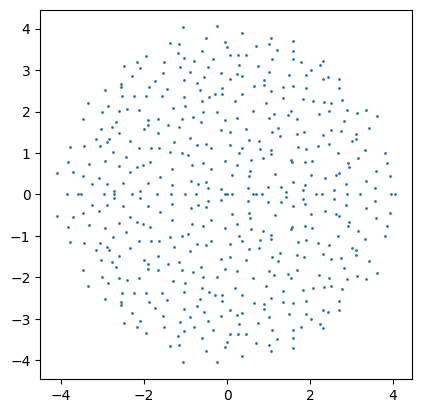

In [199]:
# plot spectra
[fig, subfig_s] = plt.subplots(1, int(connectivity_n), squeeze = False)
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[0, connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[0, connectivity_idx].set_aspect('equal')

In [200]:
h_s=[0 for wave_idx in range(wave_n)]
r_s=[0 for wave_idx in range(wave_n)]

joined_time_interval = jnp.array([0, interval_len])
temp_traj_holder = traj_initializer(init_condition_s[0], joined_time_interval, resolution)
for wave_idx in range(wave_n):
  temp_traj = temp_traj_holder.at[..., 0].set(init_condition_s[0])
  temp_traj = rk4_ode_solver(
    lambda position:
    almlin_velocity_fct(connectivity_s[0], position),
    lambda time:
    sin_ext_input_fct(
      wave_s[wave_idx],#jnp.array([0,0]), 
      ext_connectivity_s[0], phase_s[0],
      labeled_time_interval_s, time),
    temp_traj,
    joined_time_interval[0], resolution)
  h_s[wave_idx]=temp_traj
  r_s[wave_idx]=jnp.tanh(temp_traj)

In [201]:
# for nonEI
# print(jnp.mean(r_s[1]), jnp.mean(jsig@r_s[1]), 
#       jnp.mean(jrandom.normal(jrandom.PRNGKey(round(time.time())),(part_n,part_n))@r_s[1]))

In [202]:
print(jnp.var(jnp.mean(h_s[0],axis=0)), jnp.var(jnp.full((1,part_n),1) @ h_s[0]/part_n))
print(jnp.var(h_s[0]), jnp.var(jnp.full((1,part_n),1) @ h_s[0]/jnp.sqrt(part_n)))

3.1932795 3.193279
7.2938447 1596.6396


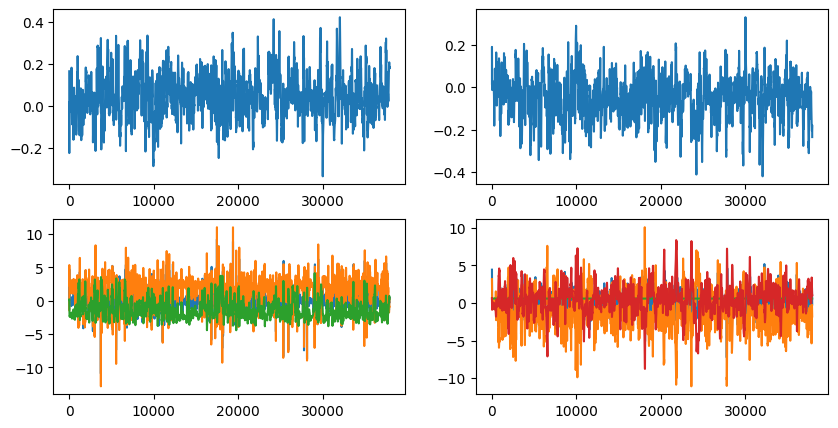

In [203]:
jmu=(connectivity_s_generator(sub_part_n_s, unscaled_mean, jnp.array([[0]]), 
                                        jnp.array([[0]]),
                           1,key)[0] - suppression)[0]
jsig=connectivity_s[0]-jmu
vvec=jmu[0:1]
hhat=jnp.mean(h_s[1], axis = 0)
rhat=jnp.mean(r_s[1],axis=0)
htld=h_s[1] - hhat
rtld=r_s[1] - rhat

# plt.plot(jnp.mean(h_s[1], axis = -1)
#          -ext_connectivity_s[0,:,0]*wave_s[1,0]
#          -jnp.mean(jsig @ (r_s[1] - jnp.mean(r_s[1], axis = 0)), axis =-1)
#          -jnp.mean(h_s[1]), linestyle='',marker='.')

[fig, subfig_s] = plt.subplots(2, 2, squeeze = False,figsize=(10,5))
subfig_s[0,0].plot(jnp.gradient(hhat)*resolution-( -hhat+(vvec @ rtld)[0]))
subfig_s[0,1].plot((jnp.gradient(htld, axis=-1)*resolution
                    -(-htld+jsig @ rtld+ext_connectivity_s[0]*wave_s[1,0]))[0])
subfig_s[1,0].plot(-hhat+(vvec @ rtld)[0])
subfig_s[1,0].plot((vvec @ rtld)[0])
subfig_s[1,0].plot(-hhat)
subfig_s[1,1].plot((-htld+jsig @ rtld+ext_connectivity_s[0]*wave_s[1,0])[0])
subfig_s[1,1].plot((jsig @ rtld)[0])
subfig_s[1,1].plot(hhat*0+(ext_connectivity_s[0]*wave_s[1,0])[0,0])
subfig_s[1,1].plot((-htld)[0])

-0.010634714 -0.10374499


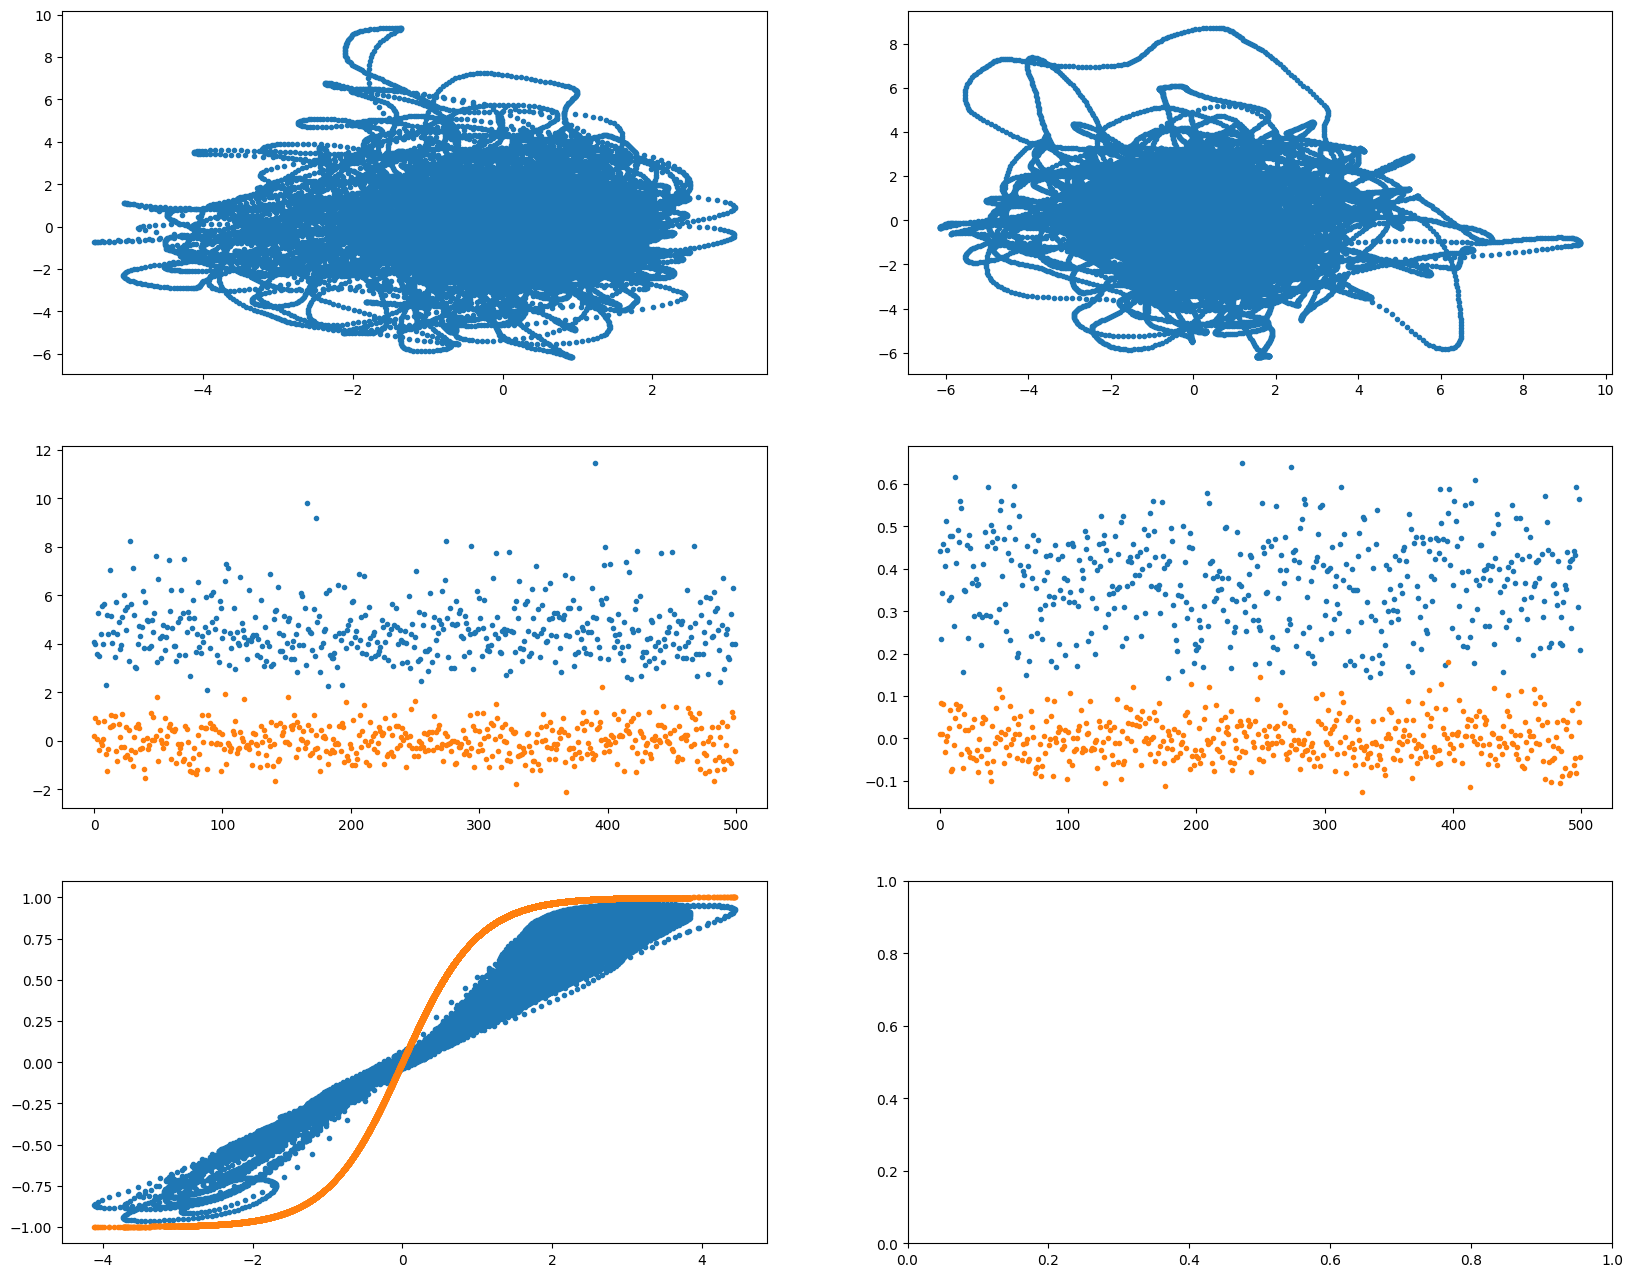

In [204]:
htldfluct=htld-jnp.mean(htld,axis=1,keepdims=True)
rtldfluct=rtld-jnp.mean(rtld,axis=1,keepdims=True)
hhatfluct=hhat-jnp.mean(hhat)
rhatfluct=rhat-jnp.mean(rhat)

htldcov = htldfluct@htldfluct.T / joined_time_interval[1]/resolution
rtldcov = rtldfluct@rtldfluct.T / joined_time_interval[1]/resolution

lmsty=['','.']
pltidx1=round(time.time())%part_n
pltidx2=round(time.time()+2)%part_n
[fig, subfig_s] = plt.subplots(3, 2, squeeze = False,figsize=(20,16))
subfig_s[0,0].plot(hhatfluct,htldfluct[pltidx1], linestyle=lmsty[0],marker=lmsty[1])
subfig_s[0,1].plot(htldfluct[pltidx1],htldfluct[pltidx2], linestyle=lmsty[0],marker=lmsty[1])
print(jnp.corrcoef(hhatfluct,htldfluct[pltidx1])[0,1],jnp.corrcoef(htldfluct[pltidx1],htldfluct[pltidx2])[0,1])
# subfig_s[0,0].plot(rhatfluct,rtldfluct[pltidx1], linestyle=lmsty[0],marker=lmsty[1])
# subfig_s[0,1].plot(rtldfluct[pltidx1],rtldfluct[pltidx2], linestyle=lmsty[0],marker=lmsty[1])
# print(jnp.corrcoef(rhatfluct,rtldfluct[pltidx1])[0,1],jnp.corrcoef(rtldfluct[pltidx1],rtldfluct[pltidx2])[0,1])

subfig_s[1,0].plot(jnp.diag(htldcov), linestyle=lmsty[0],marker=lmsty[1])#acov
subfig_s[1,0].plot(htldcov[jnp.triu_indices(part_n,1)][:part_n], linestyle=lmsty[0],marker=lmsty[1])#ccov
subfig_s[1,1].plot(jnp.diag(rtldcov), linestyle=lmsty[0],marker=lmsty[1])#acov
subfig_s[1,1].plot(rtldcov[jnp.triu_indices(part_n,1)][:part_n], linestyle=lmsty[0],marker=lmsty[1])#ccov

subfig_s[2,0].plot(hhat,rhat, linestyle=lmsty[0],marker=lmsty[1])
subfig_s[2,0].plot(hhat,jnp.tanh(hhat), linestyle=lmsty[0],marker=lmsty[1])
# subfig_s[2,0].plot(hhat,hhat/e_mean, linestyle=lmsty[0],marker=lmsty[1])
# subfig_s[2,1].plot(, linestyle=lmsty[0],marker=lmsty[1])

corr -0.019848308
glob mean decomp 1.2921231 0.0 0.0 1.3401078
glob mean std over realizations 2.5331848


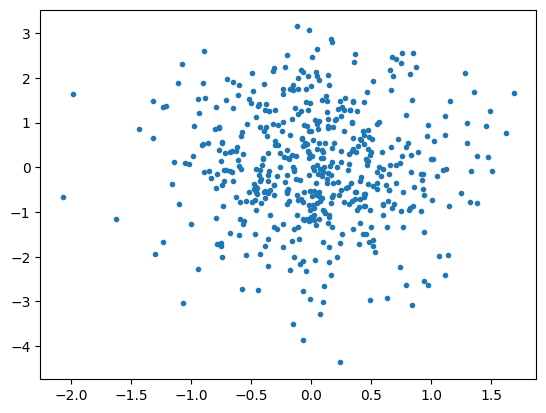

In [205]:
plt.figure()
plt.plot(ext_connectivity_s[0,:,0]*wave_s[1,0],
         jnp.mean(jsig @ rtld, axis =-1), linestyle='',marker='.')
print("corr",jnp.corrcoef(ext_connectivity_s[0,:,0]*wave_s[1,0],jnp.mean(connectivity_s[0] @ rtld, axis =-1))[0,1])

print("glob mean decomp",
      (vvec @ jnp.mean(rtld,axis=1,keepdims=True))[0,0], 
      -suppression*part_n * jnp.mean(r_s[1]),#jnp.sum(vvec) * jnp.mean(r_s[1]),
      ext_mean*wave_s[1,0],
      jnp.mean(h_s[1]))
print("glob mean std over realizations", jnp.sqrt(e_part_r/(1-e_part_r))*e_mean*jnp.std(jnp.mean(rtld,axis=1)))

In [206]:
print(jnp.var(vvec @ rtld), (vvec**2 @ jnp.var(rtld,axis=1,keepdims=True))[0,0])
print(jnp.var(jsig @ rtld), unscaled_std[0,0]**2 * jnp.var(rtld), unscaled_std[0,0]**2 * jnp.var(r_s[1]))

3.1200068 23.930109
7.544601 7.522685 10.026044


In [207]:
rhatacov=matched_correlation_fct(rhat, rhat, jnp.mean(rhat), jnp.mean(rhat))
rtldacov=matched_correlation_fct(rtld, rtld, jnp.mean(rtld, axis=1), jnp.mean(rtld, axis=1))
racov=matched_correlation_fct(r_s[1], r_s[1], jnp.mean(r_s[1], axis=1), jnp.mean(r_s[1], axis=1))

In [218]:
foo=(r_s[0]-jnp.mean(r_s[0], axis=1,keepdims=True))@(r_s[0]-jnp.mean(r_s[0],
                                                           axis=1,keepdims=True)).T/resolution/interval_len
dim_r_s_fct(es_s_fct(foo)[0])

Array(0.00590468, dtype=float32)

23.673716 23.83269 23.148516 23.971197 19.683369 3.1200068


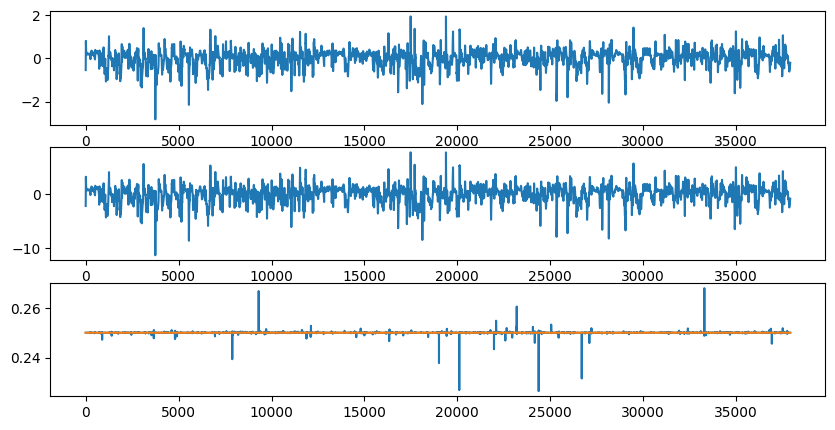

In [208]:
print(
  jnp.var(rtldfluct)*e_part_r/(1-e_part_r)*e_mean**2,
  jnp.var((jrandom.normal(jrandom.PRNGKey(7783), (100,part_n))*jnp.sqrt(e_part_r/(1-e_part_r)*e_mean**2/part_n) 
           @ jrandom.normal(jrandom.PRNGKey(767367), (part_n,100))*jnp.std(rtldfluct))),
  jnp.var((jrandom.normal(jrandom.PRNGKey(7783), (100,part_n))*jnp.sqrt(e_part_r/(1-e_part_r)*e_mean**2/part_n) 
           @ rtldfluct)),
  jnp.var(vvec
           @ jrandom.normal(jrandom.PRNGKey(767367), (part_n,100))*jnp.std(rtldfluct)),
  jnp.var(vvec[:,::-1] @ rtldfluct),
  jnp.var(vvec @ rtldfluct))

[fig, subfig_s] = plt.subplots(3,1, squeeze = False,figsize=(10,5))
subfig_s[0,0].plot((vvec[:,:sub_part_n_s[0]] @ rtldfluct[:sub_part_n_s[0]])[0])
# subfig_s[0,0].plot(hhat*0+(vvec[:,:sub_part_n_s[0]] @ jnp.mean(rtld,axis=1,keepdims=True)[:sub_part_n_s[0]])[0])
subfig_s[1,0].plot((vvec[:,sub_part_n_s[0]:] @ rtldfluct[sub_part_n_s[0]:])[0])
# subfig_s[1,0].plot(hhat*0+(vvec[:,sub_part_n_s[0]:] @ jnp.mean(rtld,axis=1,keepdims=True)[sub_part_n_s[0]:])[0])
subfig_s[2,0].plot((vvec[:,:sub_part_n_s[0]] @ rtldfluct[:sub_part_n_s[0]])[0]/
                   (vvec[:,sub_part_n_s[0]:] @ rtldfluct[sub_part_n_s[0]:])[0])
subfig_s[2,0].plot(hhat*0
                   +(vvec[:,:sub_part_n_s[0]] @ jnp.mean(rtld,axis=1,keepdims=True)[:sub_part_n_s[0]])[0]/(vvec[:,sub_part_n_s[0]:] @ jnp.mean(rtld,axis=1,keepdims=True)[sub_part_n_s[0]:])[0])

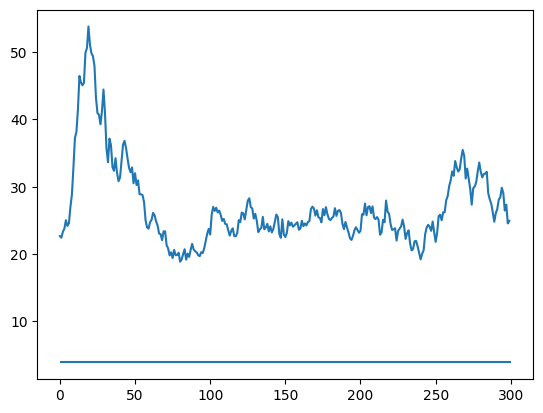

In [209]:
plt.plot(jnp.array([jnp.var(jnp.sum(rtldfluct[::-1][sub_part_n_s[1]:][idx:sub_part_n_s[1]+idx],axis=0)) 
       for idx in range(sub_part_n_s[0]-sub_part_n_s[1])]))
plt.hlines(jnp.var(jnp.sum(rtldfluct[::-1][:sub_part_n_s[1]],axis=0)),0,300)

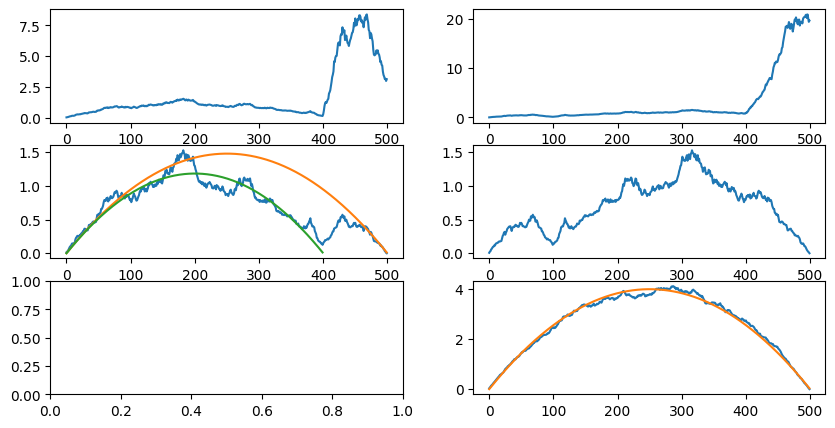

In [210]:
[fig, subfig_s] = plt.subplots(3,2, squeeze = False,figsize=(10,5))
subfig_s[0,0].plot(jnp.var(jnp.cumsum(rtldfluct*vvec.T, axis =0), axis = 1))
subfig_s[0,1].plot(jnp.var(jnp.cumsum((rtldfluct[::-1]*vvec.T), axis =0), axis = 1))
subfig_s[1,0].plot(jnp.var(jnp.cumsum(rtldfluct*vvec[0,0], axis =0), axis = 1))
subfig_s[1,0].plot([idx*(part_n-idx)*jnp.mean(jnp.var(rtldfluct,axis=1))/part_n**2*e_mean**2 
                    for idx in range(part_n)])
subfig_s[1,0].plot([idx*(sub_part_n_s[0]-idx)*jnp.mean(jnp.var(rtldfluct,axis=1))/part_n/sub_part_n_s[0]*e_mean**2 
                    for idx in range(sub_part_n_s[0])])
subfig_s[1,1].plot(jnp.var(jnp.cumsum(rtldfluct[::-1]*vvec[0,0], axis =0), axis = 1))
subfig_s[2,1].plot(jnp.var(jnp.cumsum(jsig, axis =1), axis = 0))
subfig_s[2,1].plot([idx*(part_n-idx)*unscaled_std[0,0]**2/part_n**2 for idx in range(part_n)])

In [211]:
print(jnp.mean(jnp.var(rtld,axis=1)), jnp.var(rtld-jnp.mean(rtld, axis=1, keepdims=True)), 
      jnp.var(rtld))

0.3699018 0.3699018 0.47016782


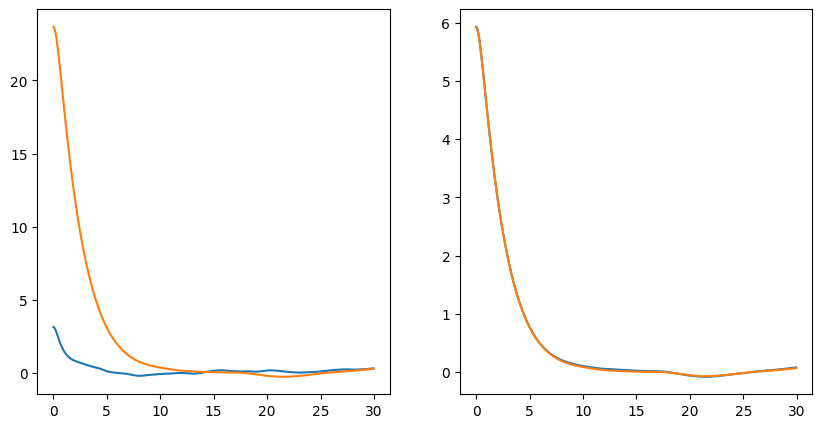

In [212]:
hhateta=(vvec @ rtld)[0]
htldeta=jsig @ rtld
foo=matched_correlation_fct(hhateta, hhateta, jnp.mean(hhateta), jnp.mean(hhateta))
bar=matched_correlation_fct(htldeta, htldeta, jnp.mean(htldeta, axis=1), jnp.mean(htldeta, axis=1))

[fig, subfig_s] = plt.subplots(1, 2, squeeze = False,figsize=(10,5))
subfig_s[0,0].plot(jnp.arange(resolution * 30)/resolution, foo[:resolution * 30])
subfig_s[0,0].plot(jnp.arange(resolution * 30)/resolution, e_part_r/(1-e_part_r)*e_mean**2*jnp.mean(rtldacov, axis = 0)[:resolution * 30])
subfig_s[0,1].plot(jnp.arange(resolution * 30)/resolution, jnp.mean(bar, axis=0)[:resolution * 30])
subfig_s[0,1].plot(jnp.arange(resolution * 30)/resolution, unscaled_std[0,0]**2*jnp.mean(rtldacov, axis = 0)[:resolution * 30])

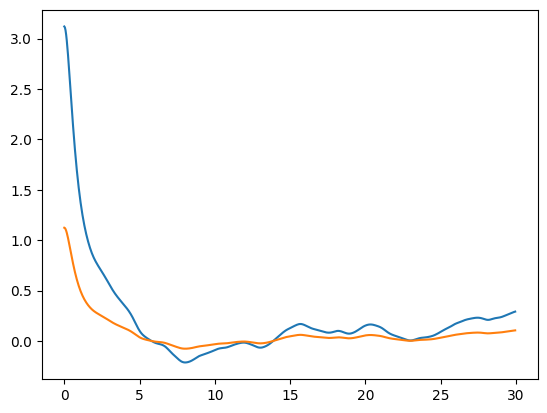

In [213]:
hhatetan=(jnp.abs(vvec) @ rtld)[0]
qux=matched_correlation_fct(hhatetan, hhatetan, jnp.mean(hhatetan), jnp.mean(hhatetan))

plt.plot(jnp.arange(resolution * 30)/resolution, foo[:resolution * 30])
plt.plot(jnp.arange(resolution * 30)/resolution, qux[:resolution * 30])

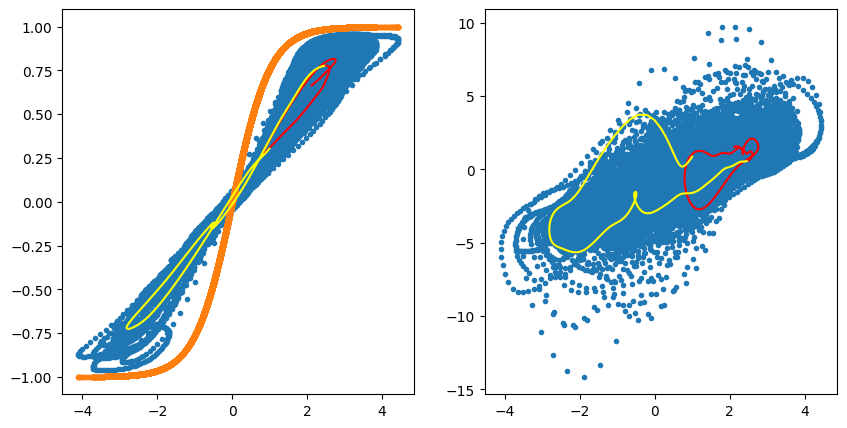

In [214]:
test_time=jnp.round((jrandom.uniform(jrandom.PRNGKey(round(time.time())))
                     +jnp.array([0,0.005,0.01]))
               *interval_len*resolution).astype(int)
[fig, subfig_s] = plt.subplots(1, 2, squeeze = False,figsize=(10,5))
subfig_s[0,0].plot(hhat,rhat, linestyle=lmsty[0],marker=lmsty[1])
subfig_s[0,0].plot(hhat,jnp.tanh(hhat), linestyle=lmsty[0],marker=lmsty[1])
subfig_s[0,0].plot(hhat[test_time[0]:test_time[1]],rhat[test_time[0]:test_time[1]],color='red')
subfig_s[0,0].plot(hhat[test_time[1]:test_time[2]],rhat[test_time[1]:test_time[2]],color='yellow')
# subfig_s[0,1].plot(hhat,hhateta, linestyle=lmsty[0],marker=lmsty[1])
# subfig_s[0,1].plot(hhat[test_time[0]:test_time[1]],hhateta[test_time[0]:test_time[1]],color='red')
# subfig_s[0,1].plot(hhat[test_time[1]:test_time[2]],hhateta[test_time[1]:test_time[2]],color='yellow')
hhatxi = hhateta - jnp.mean(hhateta)
subfig_s[0,1].plot(hhat,hhatxi, linestyle=lmsty[0],marker=lmsty[1])
subfig_s[0,1].plot(hhat[test_time[0]:test_time[1]],hhatxi[test_time[0]:test_time[1]],color='red')
subfig_s[0,1].plot(hhat[test_time[1]:test_time[2]],hhatxi[test_time[1]:test_time[2]],color='yellow')
# htldximean = jnp.mean(htldeta - jnp.mean(htldeta, axis=1,keepdims=True),axis=0)
# subfig_s[0,2].plot(hhat,htldximean, linestyle=lmsty[0],marker=lmsty[1])
# subfig_s[0,2].plot(hhat[test_time[0]:test_time[1]],htldximean[test_time[0]:test_time[1]],color='red')
# subfig_s[0,2].plot(hhat[test_time[1]:test_time[2]],htldximean[test_time[1]:test_time[2]],color='yellow')

(0.0, 30.0)

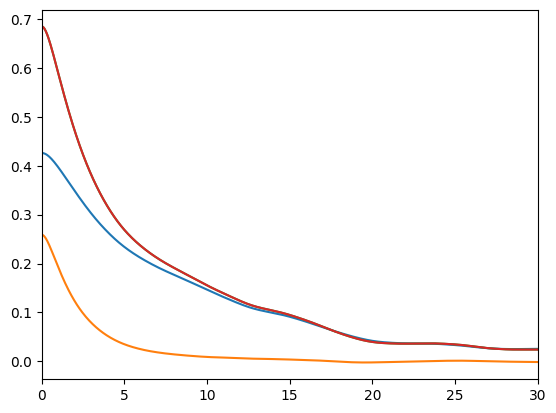

In [200]:
plt.plot(jnp.arange(resolution * 30)/resolution, rhatacov[:resolution * 30])
plt.plot(jnp.arange(resolution * 30)/resolution, jnp.mean(rtldacov, axis = 0)[:resolution * 30])
plt.plot(jnp.arange(resolution * 30)/resolution, jnp.mean(racov, axis = 0)[:resolution * 30])
plt.plot(jnp.arange(resolution * 30)/resolution, (rhatacov+jnp.mean(rtldacov, axis = 0))[:resolution * 30])

plt.xlim(0,30)

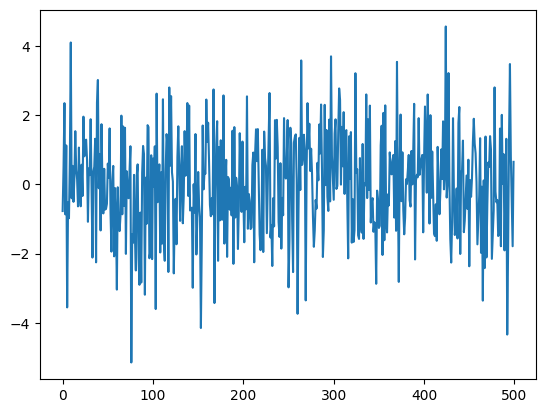

In [534]:
plt.plot(jnp.mean(h_s[1] - jnp.mean(h_s[1],axis=0), axis = 1, keepdims=True)) # time averages

0.67640704 21.38987


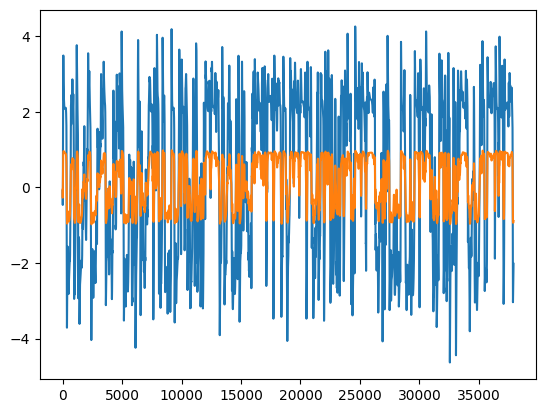

In [417]:
plt.plot(jnp.mean(h_s[1],axis=0))
plt.plot(jnp.mean(r_s[1],axis=0))
print(jnp.std(jnp.mean(r_s[1],axis=0)),
      jnp.std(jnp.mean(r_s[1],axis=0)* jnp.sqrt(part_n))) # which is O(1)

In [ ]:
r_mean_s = [jnp.mean(r_s[wave_idx], axis = -1) for wave_idx in range(wave_n)]
r_var_mean = [jnp.mean(jnp.var(r_s[wave_idx] - jnp.expand_dims(r_mean_s[wave_idx], 1), axis = -1)) 
              for wave_idx in range(wave_n)]
r_var_sq = [jnp.mean((jnp.var(r_s[wave_idx] - jnp.mean(r_s[wave_idx], axis = -1, keepdims=True), axis = -1) 
                     / r_var_mean[wave_idx])**2) 
            for wave_idx in range(wave_n)]
r_mod_sq = [jnp.mean(jnp.mean(r_s[wave_idx]**2, axis = -1)**2)/jnp.mean(jnp.mean(r_s[wave_idx]**2, axis = -1))**2
            for wave_idx in range(wave_n)]

r_acov_s = [matched_correlation_fct(r_s[wave_idx], r_s[wave_idx], r_mean_s[wave_idx], r_mean_s[wave_idx]) 
            for wave_idx in range(wave_n)]
r_ccov_s = [jnp.array([matched_correlation_fct(jnp.roll(r_s[wave_idx], shift, axis = 0), r_s[wave_idx], 
                                   jnp.roll(r_mean_s[wave_idx], shift, axis = 0), r_mean_s[wave_idx])
                      for shift in jnp.arange(1,1+4)]) 
            for wave_idx in range(wave_n)]

cov = [cov_s_fct(r_s[wave_idx], r_mean_s[wave_idx]) for wave_idx in range(wave_n)]
es = [es_s_fct(cov[wave_idx]) for wave_idx in range(wave_n)]
pr = [dim_r_s_fct(es[wave_idx][0]) for wave_idx in range(wave_n)]

r var s 0.26935786 1.7445353
r mod sq 1.0307049


(0.0, 30.0)

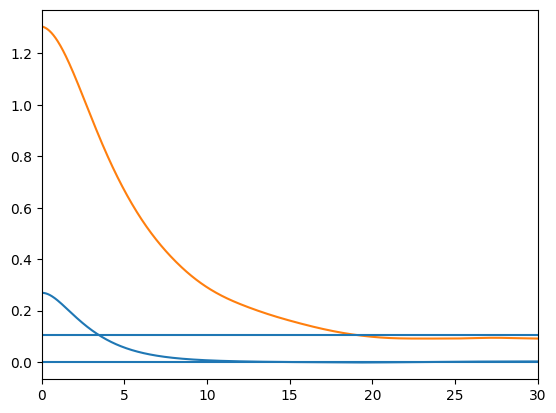

In [166]:
test_idx = 1

print("r var s", r_var_mean[test_idx], r_var_sq[test_idx])
print("r mod sq", r_mod_sq[test_idx])

plt.plot(jnp.arange(resolution * 30)/resolution, jnp.mean(r_acov_s[test_idx], axis = 0)[:resolution * 30])
plt.plot(jnp.arange(resolution * 30)/resolution, part_n * jnp.mean(r_ccov_s[test_idx][:,:,:resolution * 30] ** 2, 
                                                                   axis = (0,1)))
plt.hlines([0,jnp.mean(r_ccov_s[test_idx][:,:,resolution * 300] ** 2) * part_n], 0, 30)
plt.xlim(0,30)

point no sq 0.00010955369
seg 0.011445125 1.3047476


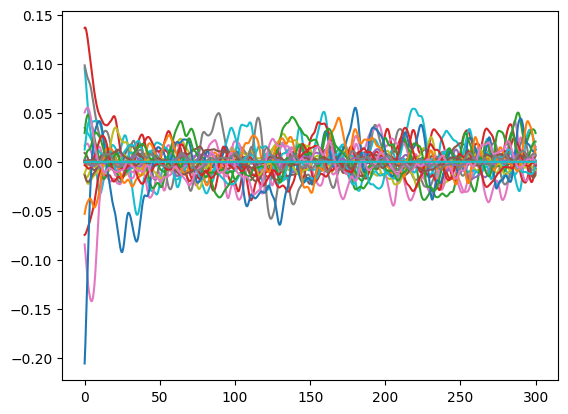

In [168]:
for idx in range(50):
  plt.plot(jnp.arange(resolution * 300)/resolution, r_ccov_s[test_idx][0,idx,:resolution * 300])
print("point no sq",jnp.mean(r_ccov_s[test_idx][0,:,resolution * 300])**2*part_n)
print("seg",jnp.mean(jnp.mean(r_ccov_s[test_idx][0,:,resolution * 200:resolution * 300], axis= -1)**2)*part_n,
      jnp.mean(r_ccov_s[test_idx][:,:,0] ** 2)*part_n)

pr 0.05428225
cij sq 1.2618191 1.2100327


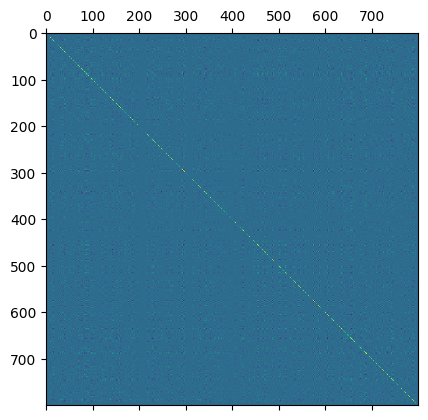

In [162]:
print("pr",pr[test_idx])
print("cij sq",jnp.mean(r_acov_s[test_idx][:,0])**2 / pr[test_idx] - r_mod_sq[test_idx] * jnp.mean(r_acov_s[test_idx][:,0]) **2, 
      (jnp.sum(cov[test_idx] ** 2) - jnp.trace(cov[test_idx] ** 2))/part_n)
plt.matshow(cov[test_idx])

(0.0, 300.0)

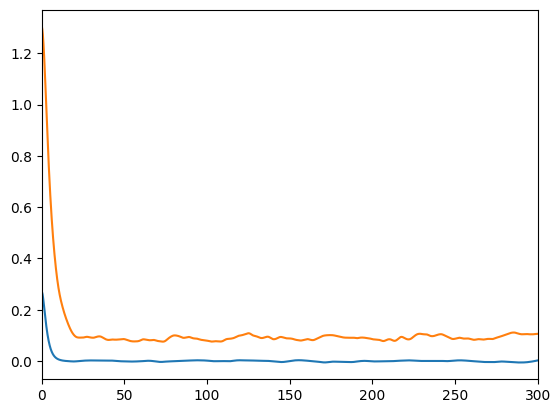

In [163]:
plt.plot(jnp.arange(resolution * 300)/resolution, jnp.mean(r_acov_s[test_idx], axis = 0)[:resolution * 300])
plt.plot(jnp.arange(resolution * 300)/resolution, part_n * jnp.mean(r_ccov_s[test_idx] ** 2, axis = (0,1))[:resolution * 300])
plt.xlim(0,300)

In [134]:
# plt.plot(jnp.arange(resolution * 30)/resolution, 
#          jnp.mean(r_acov_s[test_idx], axis = 0)[:resolution * 30] / jnp.mean(r_acov_s[test_idx], axis = 0)[0])
# plt.plot(jnp.arange(resolution * 30)/resolution, 
#          ((jnp.mean(r_ccov_s[test_idx] ** 2, axis = (0,1))[:resolution * 30] - jnp.mean(r_ccov_s[test_idx] ** 2, axis = (0,1))[resolution * 300])
#           / (jnp.mean(r_ccov_s[test_idx] ** 2, axis = (0,1))[0]-jnp.mean(r_ccov_s[test_idx] ** 2, axis = (0,1))[resolution * 300])))
# plt.xlim(0,30)

In [5]:
kernel_power = 2 # jnp.inf
max_kernel_fraction = 0.4 # 0.96

samp_sep_with_n = samp_sep_with_n_fct(window_len_s, waiting_time, interval_len,
                                      max_kernel_fraction, resolution)
kernel_s = kernel_s_fct(window_len_s, resolution, kernel_power, max_kernel_fraction)

# initialize and run stats

def short_multi_len_secondary_stat_s_fct(traj):
  return(multi_len_secondary_stat_s_fct(traj[..., (waiting_time * resolution):], resolution,
                                        kernel_s, samp_sep_with_n))

start_time = time.time()

stat_s_free = multi_len_secondary_stat_s_initializer(condition_n_s_free, window_len_s, samp_sep_with_n[1])
stat_s_free = stat_s_fct(connectivity_s, wave_s[:1], ext_connectivity_s[:1], phase_s[:1], init_condition_s,
                         labeled_time_interval_s_free, resolution,
                         short_multi_len_secondary_stat_s_fct, stat_s_free)
np.savez_compressed(subdirectory + "stats_free.npz", *stat_s_free) # jax has not implemented savez_compressed as of 23/08/23

stat_s = multi_len_secondary_stat_s_initializer(condition_n_s, window_len_s, samp_sep_with_n[1])
stat_s = stat_s_fct(connectivity_s, wave_s, ext_connectivity_s, phase_s, init_condition_s[::ext_condition_n],
                    labeled_time_interval_s, resolution, 
                    short_multi_len_secondary_stat_s_fct, stat_s)
np.savez_compressed(subdirectory + "stats.npz", *stat_s)

end_time = time.time()
print("took {:.2f} mins".format((end_time - start_time) / 60))

[2, 'connectivity_n']
[1, 'wave_n']
[1, 'ext_connectivity_n']
[1, 'phase_n']
[2, 'init_condition_n']
5 stats
expecting 0.93 mins
[2, 'connectivity_n']
[4, 'wave_n']
[1, 'ext_connectivity_n']
[1, 'phase_n']
[2, 'init_condition_n']
5 stats
expecting 3.73 mins
took 4.55 mins


In [6]:
# load trajs
stat_s_free = load_as_list(subdirectory + "stats_free.npz")
stat_s = load_as_list(subdirectory + "stats.npz")

In [7]:
#export to predictions
np.savez_compressed(subdirectory + "../../../sim_free.npz", 
                    part_n, 
                    jnp.append(window_len_s, interval_len - waiting_time), 
                    jnp.arange(samp_sep_with_n[1]) * samp_sep_with_n[0] / resolution, 
                    *stat_s_free)
np.savez_compressed(subdirectory + "../../../sim.npz", 
                    part_n, 
                    jnp.append(window_len_s, interval_len - waiting_time), 
                    jnp.arange(samp_sep_with_n[1]) * samp_sep_with_n[0] / resolution, 
                    *stat_s)

plotting

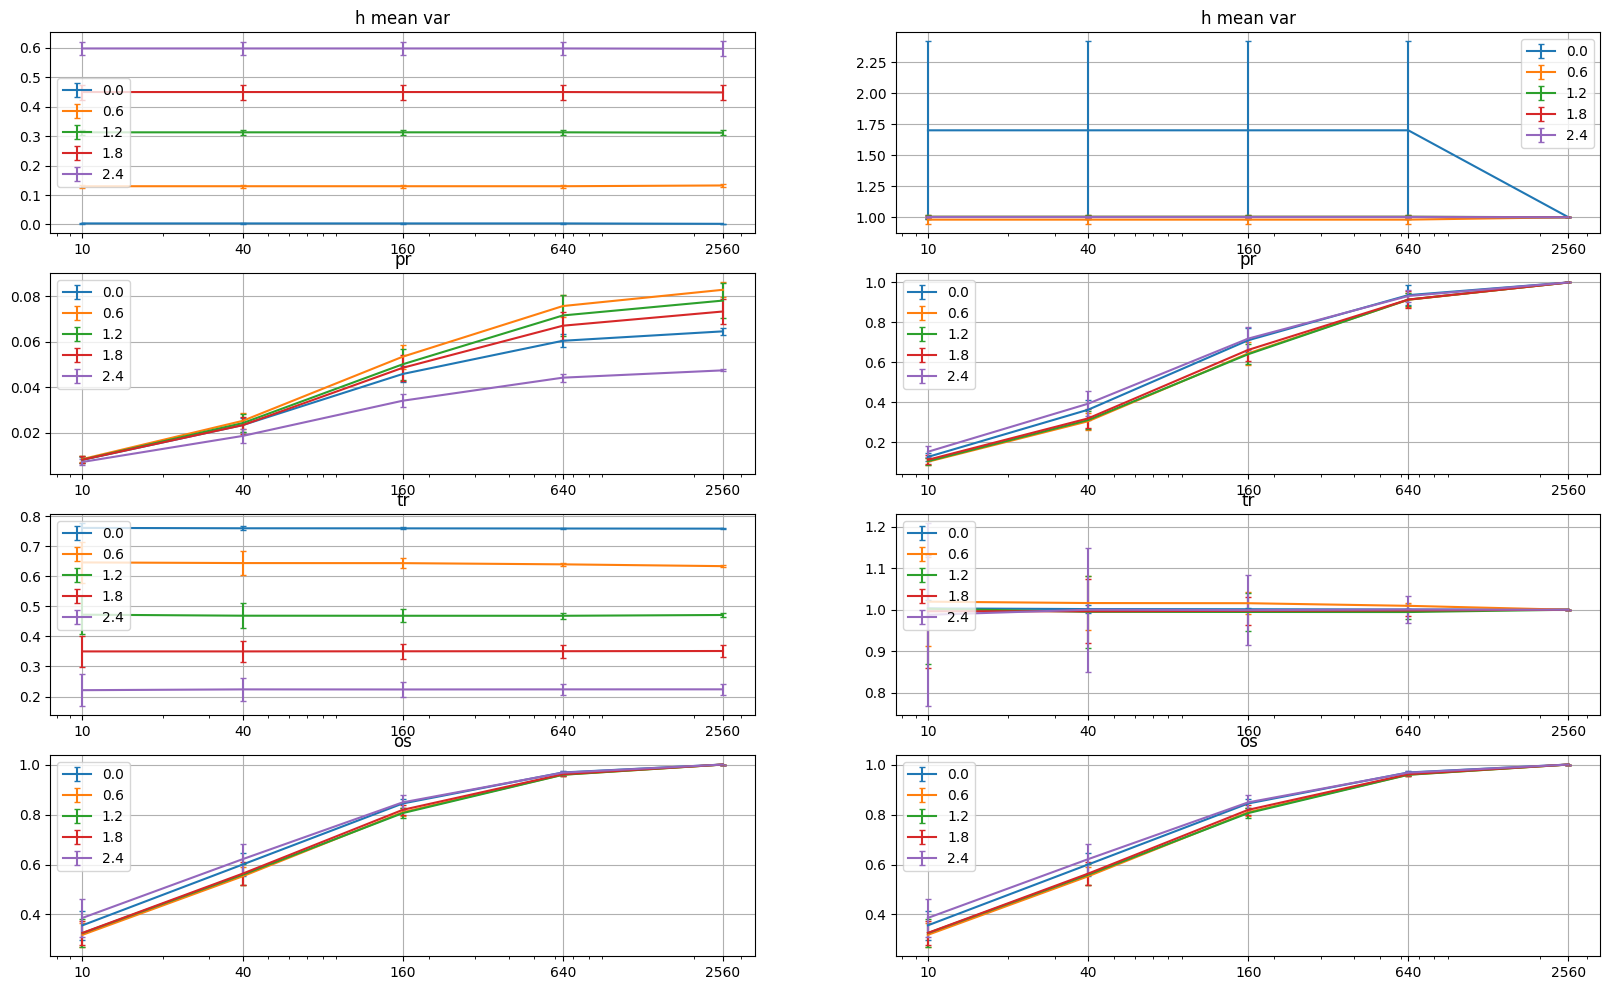

In [8]:
def temp_val_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s, axis = (0,2,3,4, 6))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

def temp_r_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s / stat_s[...,-1:,:], axis = (0,2,3,4, 6))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

[h_mean_var_s_free, pr_s_free, tr_s_free, os_s_free, lagged_os_s_free] = stat_s_free
[h_mean_var_s, pr_s, tr_s, os_s, lagged_os_s] = stat_s

val_r_stat_s = [[temp_val_fct([h_mean_var_s_free, h_mean_var_s]), 
                 temp_val_fct([pr_s_free, pr_s]), 
                 temp_val_fct([tr_s_free, tr_s]), 
                 temp_val_fct([os_s_free, os_s])],
                [temp_r_fct([h_mean_var_s_free, h_mean_var_s]), 
                 temp_r_fct([pr_s_free, pr_s]), 
                 temp_r_fct([tr_s_free, tr_s]), 
                 temp_r_fct([os_s_free, os_s])]]

plot_amp_s = jnp.insert(amp_s, 0, 0)
plot_window_len_s = jnp.append(window_len_s, interval_len - waiting_time)
[fig, subfig_s] = plt.subplots(4, 2, figsize = (20,12))
for val_or_r in range(2):
  subfig_s[0, val_or_r].title.set_text("h mean var")
  subfig_s[1, val_or_r].title.set_text("pr")
  subfig_s[2, val_or_r].title.set_text("tr")
  subfig_s[3, val_or_r].title.set_text("os")
  for stat_idx in range(4):
    for amp_idx in range(wave_n + 1):
      subfig_s[stat_idx, val_or_r].errorbar(plot_window_len_s,
                           val_r_stat_s[val_or_r][stat_idx][0][amp_idx],
                           yerr = val_r_stat_s[val_or_r][stat_idx][1][amp_idx],
                           capsize = 2, label = str(plot_amp_s[amp_idx]))
    subfig_s[stat_idx, val_or_r].set_xscale("log")
    subfig_s[stat_idx, val_or_r].set_xticks(plot_window_len_s, labels = plot_window_len_s)
    subfig_s[stat_idx, val_or_r].legend()
    subfig_s[stat_idx, val_or_r].grid()

[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]

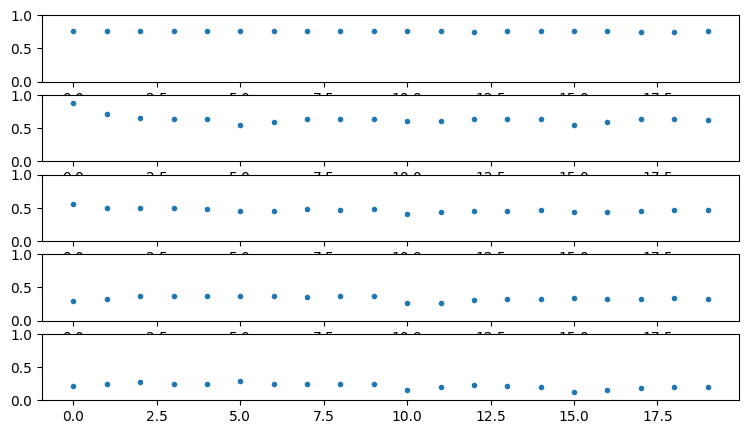

In [9]:
#making sure nothing is strange from the trs
[fig, subfig_s] = plt.subplots(wave_n + 1, 1, figsize = (9, 5))
subfig_s[0].plot(tr_s_free[..., -1].flatten(), label = 0., 
                 marker='.', linestyle='')
for wave_idx in range(wave_n):
  subfig_s[wave_idx + 1].plot(tr_s[:, wave_idx, ..., -1].flatten(), label = amp_s[wave_idx, 0],
                              marker='.', linestyle='')
plt.setp(subfig_s, ylim=(0,1))

n=500 freq=0.1

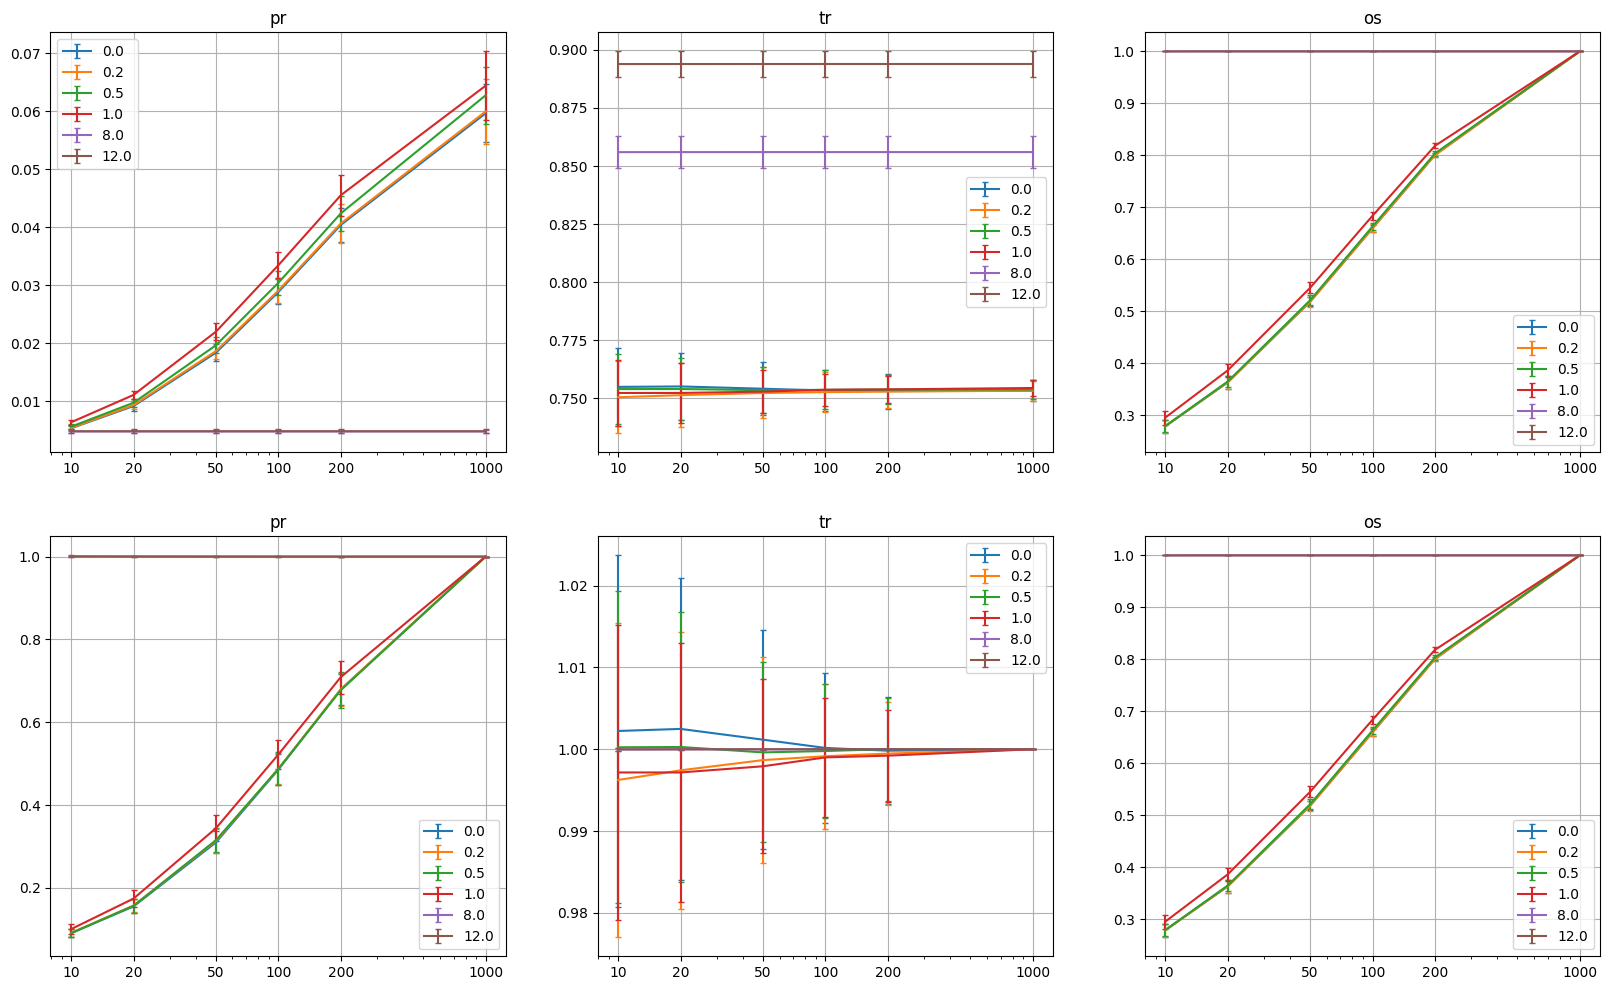

In [12]:
def temp_val_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s, axis = (0,2,3,4))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

def temp_r_fct(stat_s_wrt_amp_s):
  return([jnp.concatenate([fct(stat_s / stat_s[...,-1:], axis = (0,2,3,4))
                           for stat_s in stat_s_wrt_amp_s], axis = 0)
          for fct in [jnp.mean, jnp.std]])

val_r_stat_s = [[temp_val_fct([pr_s_free, pr_s]), 
                 temp_val_fct([tr_s_free, tr_s]), 
                 temp_val_fct([os_s_free, os_s])],
                [temp_r_fct([pr_s_free, pr_s]), 
                 temp_r_fct([tr_s_free, tr_s]), 
                 temp_r_fct([os_s_free, os_s])]]

plot_amp_s = jnp.insert(amp_s, 0, 0)
plot_window_len_s = jnp.append(window_len_s, interval_len - waiting_time)
[fig, subfig_s] = plt.subplots(2, 3, figsize = (20,12))
for val_or_r in range(2):
  subfig_s[val_or_r,0].title.set_text("pr")
  subfig_s[val_or_r,1].title.set_text("tr")
  subfig_s[val_or_r,2].title.set_text("os")
  for stat_idx in range(3):
    for amp_idx in range(wave_n + 1):
      subfig_s[val_or_r,stat_idx].errorbar(plot_window_len_s,
                           val_r_stat_s[val_or_r][stat_idx][0][amp_idx],
                           yerr = val_r_stat_s[val_or_r][stat_idx][1][amp_idx],
                           capsize = 2, label = str(plot_amp_s[amp_idx]))
    subfig_s[val_or_r,stat_idx].set_xscale("log")
    subfig_s[val_or_r,stat_idx].set_xticks(plot_window_len_s, labels = plot_window_len_s)
    subfig_s[val_or_r,stat_idx].legend()
    subfig_s[val_or_r,stat_idx].grid()